In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms

from GAN.cifar10_fully_connected import (
    Generator,
    Discriminator,
    GeneratorLoss,
    DiscriminatorLoss
)

In [9]:
if torch.cuda.is_available(): device = torch.device('cuda')
elif torch.backends.mps.is_available(): device = torch.device('mps')
else: device = torch.device('cpu')
print(f'Using device: {device}')

Using device: mps


In [10]:
seed = 42
torch.manual_seed(seed)

In [ ]:
def save_plot(
        Generator: nn.Module,
        Z_noise: list[torch.Tensor],
        nrows: int,
        ncols: int,
        figsize: tuple[int, int],
        epoch: int
    ) -> None:
    """Saves images to create a GIF"""
    if not os.path.isdir('./cifar10_images'):
        os.makedirs('./cifar10_images')
    
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize)  
    ax = ax.flatten() 
    images = [Generator(z).view(3, 32, 32).permute(1, 2, 0).detach().cpu().numpy() for z in Z_noise]
    for i in range(nrows * ncols):
        ax[i].imshow(images[i].clip(0, 1))
        ax[i].axis('off')
    plt.tight_layout() 
    plt.savefig(f'./cifar10_images/{epoch}_cifar10.png')
    plt.close(fig) 

In [12]:
def load_cifar10(root: str='./cifar10/', batch_size: int=256) -> tuple[DataLoader, DataLoader]:
    """
    Loads MNIST dataset and returns it as a dataloader. 
    """ 
    transform = transforms.Compose(
        [transforms.ToTensor(),                     # greyscale [0, 255] -> [0, 1]
        transforms.Lambda(lambda x: x.view(-1))])   # shape [3, 32, 32] -> [1, 3 * 32 * 32]

    cifar10 = CIFAR10(
        root=root,
        train=True,
        download=True,
        transform=transform)
        
    dataloader = DataLoader(cifar10, batch_size=batch_size, shuffle=True)
    return dataloader

In [13]:
# Create generator and discriminator
G = Generator().to(device)
D = Discriminator().to(device)

# Hyperparameters
epochs = 100
batch_size = 100
lr_G = 0.0002
betas_G = (0.5, 0.99)
lr_D = 0.0002
betas_D = (0.5, 0.99)
verbose = True
plotting = True

# Create the optimizer and the loss
criterion_G = GeneratorLoss(maximize=True)
optimizer_G = torch.optim.Adam(params=G.parameters(), lr=lr_G, betas=betas_G, maximize=True)
criterion_D = DiscriminatorLoss()
optimizer_D = torch.optim.Adam(params=D.parameters(), lr=lr_D, betas=betas_D, maximize=True)

# Load the dataset
dataloader = load_cifar10()

Files already downloaded and verified


In [ ]:
# Plot settings (1)
figsize_1 = (8, 8)
figsize_2 = (10, 4)
nrows_1 = 4
ncols_1 = 4

Z_noise = [
    torch.distributions.uniform.Uniform(low=-1, high=1).sample([1, 100]).to(device)
    for _ in range(nrows_1*ncols_1)
]

# Plot settings (2)
figsize_2 = (10, 4)
nrows_2 = 2
ncols_2 = 5

epoch: 0 loss generator: -0.9982 loss discriminator: -1.3127


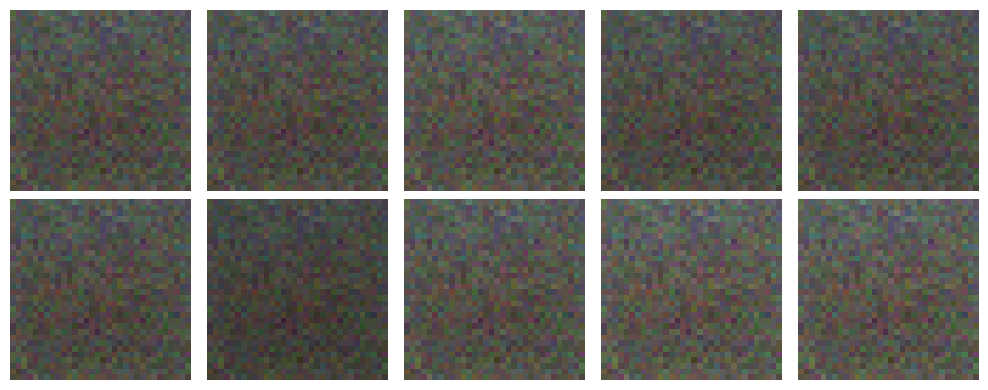

epoch: 1 loss generator: -0.8496 loss discriminator: -1.0572


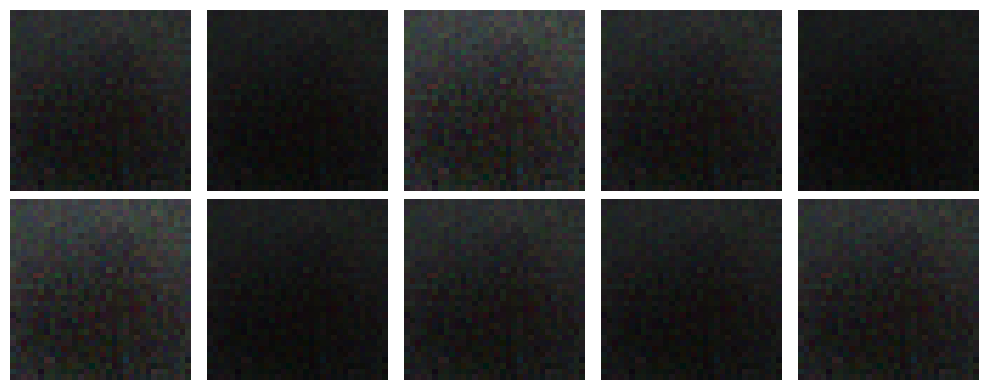

epoch: 2 loss generator: -1.0595 loss discriminator: -1.0039


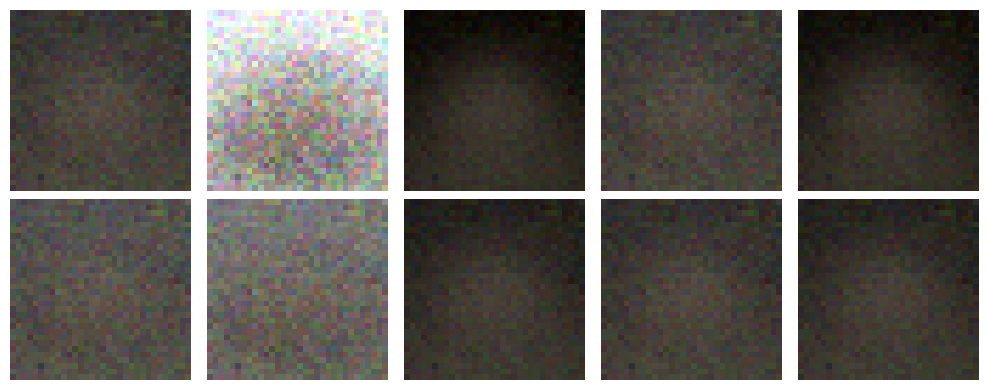

KeyboardInterrupt: 

In [ ]:
losses_D, losses_G = [], []
N = len(dataloader.dataset)
for epoch in range(epochs):

    total_loss_G, total_loss_D = 0.0, 0.0
    for x, _ in dataloader:
        # x is sampled from data generating distribution x ~ p_data
        x = x.to(device)

        # z is sampled from noise prior z ~ p_noise
        z = torch.distributions.uniform.Uniform(low=-1, high=1).sample([x.shape[0], 100]).to(device)
        D_x = D(x)
        D_G_z = D(G(z))

        # update descriminator by ascending its stochastic gradient
        optimizer_D.zero_grad()
        loss_d = criterion_D(D_x, D_G_z)
        loss_d.backward()
        optimizer_D.step()
        
        # z is sampled from noise prior
        # z ~ p_noise
        z = torch.distributions.uniform.Uniform(low=-1, high=1).sample([x.shape[0], 100]).to(device)
        D_G_z = D(G(z))

        # update generator by descending its stochastic gradient
        optimizer_G.zero_grad()
        loss_g = criterion_G(D_G_z)
        loss_g.backward()
        optimizer_G.step()

        total_loss_D += loss_d.item() * x.shape[0]
        total_loss_G += loss_g.item() * z.shape[0]
    losses_D.append(total_loss_D / N)
    losses_G.append(total_loss_G / N)

    if verbose: 
        print(f'epoch: {epoch} loss generator: {(total_loss_G/N):.4f} loss discriminator: {(total_loss_D/N):.4f}')

    # short visualization, to see, if it works :D
    save_plot(G, Z_noise, nrows_1, ncols_1, figsize_1, epoch) 
    
    fig, ax = plt.subplots(nrows_2, ncols_2, figsize=figsize_2)  
    # fig.subplots_adjust(wspace=0, hspace=0)
    ax = ax.flatten() 
    for i in range(nrows_2 * ncols_2):
        z = torch.distributions.uniform.Uniform(low=-1, high=1).sample([1, 100]).to(device)
        G_z = G(z)
        img = G_z.view(3, 32, 32).permute(1, 2, 0).detach().cpu().numpy()
        ax[i].imshow(img.clip(0, 1))
        ax[i].axis('off')
    plt.tight_layout() 
    plt.show(fig) 

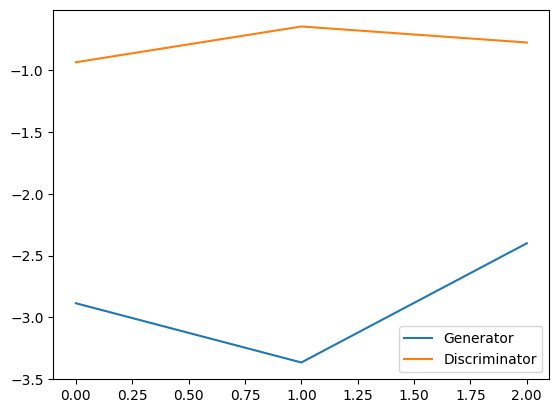

In [ ]:
x = np.arange(len(losses_G))

_, ax = plt.subplots()
ax.plot(x, losses_G, label='Generator')
ax.plot(x, losses_D, label='Discriminator')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()